In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class NormalWishart:
    """Normal-Wishart distribution.
    
    Attributes:
        _mu0 (:obj:`np.ndarray`): location vector.
        _D (int): Number of components.
        _lambda (float): positive-only scalar.
        _W (:obj:`np.ndarray`): positive definite scale matrix.
        _nu (int): number of degrees of freedom.
        _n (int): sample size.
        _0 (:obj:`np.ndarray`): pre-allocated vector of zeros.
    """
    
    def __init__(self, mu0, _lambda, W, nu, n):
        self._mu0 = np.asarray(mu0)
        self._D = self._mu0.shape[0]
        self._lambda = _lambda
        self._W = np.asarray(W)
        self._nu = nu
        self._n = n
        self._0 = np.zeros(self._nu)
        # Make sure that degrees of freedom are sufficient
        # and that the dimensionality if the scale matrix is correct.
        assert((self._nu > self._D - 1) and (len(W) == self._nu))
    
    def sample(self):
        """Randomly generates a sample of `self._n` observations.
        
        returns:
            :obj:`np.ndarray`: a random mean vector.
            :obj:`np.ndarray`: a random precision matrix.
        """
        # Randomly samples the mean vector
        mu = np.random.multivariate_normal(self._mu0, self._W)
        
        # Randomly samples the precision matrix
        G = np.random.multivariate_normal(self._0, self._W, size=self._n)
        S = np.dot(G.T, G)
        return mu, S

In [3]:
class Generator:
    """Data generator.
    
    Attributes:
        _n_inputs (int): Number of explanatory variables.
        _n_outputs (int): Number of explained variables.
        _latent_dim (int): Latent dimension, represented by the
            number of Gaussian observations to draw for
            estimating the precision matrix.
        _beta (:obj:`np.ndarray`): Variable weights.
    """
    
    def __init__(self, n_inputs, n_outputs, latent_dim=15):
        self._counter = 0
        self._n_inputs = n_inputs
        self._n_outputs = n_outputs
        self._latent_dim = latent_dim
        
        # Initializes NW distribution with the identity
        # as scale matrix and a zero vector as location vector.
        W = np.eye(self._n_inputs)
        mu0 = np.zeros(self._n_inputs)
        nu = self._n_inputs
        nw = NormalWishart(mu0, 1., W, nu, self._latent_dim)
        
        # Lambda is a random precision matrix,
        # and needs to be inverted in order to obtain
        # a covariance matrix.
        mu, Lambda = nw.sample()
        Sigma = np.linalg.inv(Lambda)
        
        # Randomly initializes the variable weights
        self._beta = np.random.multivariate_normal(mu, Sigma, self._n_outputs)
    
    def sample(self, sample_size=1):
        """Draw random samples from a multivariate Gaussian distribution.
        
        Parameters:
            sample_size (int): Number of observations to draw.
        
        Returns:
            :obj:`np.ndarray`: Array of shape (`sample_size`, `self._n_inputs`)
                containing random values for the explanatory variables.
            :obj:`np.ndarray`: Array of shape (`sample_size`, `self._n_outputs`)
                containing Random values for the explained variables.
            :obj:`np.ndarray`: Array of length `sample_size` containing the unique
                identifiers of generated samples.
        """
        # Generates unique identifiers
        counters = np.arange(self._counter, self._counter + sample_size)
        self._counter += sample_size
        
        # Samples explanatory variables
        X = np.random.rand(sample_size, self._n_inputs)
        
        # Samples random noise
        w = np.random.normal(0, 1, size=self._n_outputs) * 0.1
        
        # Computes outputs
        y = np.dot(X, self._beta.T) + w
        return np.squeeze(X), np.squeeze(y), counters
    
    @property
    def counter(self):
        """Returns current value for the sample counter.
        
        Returns:
            int: Identifier of the next sample to be generated.
        """
        return self._counter

In [24]:
class MultivariateLinearModel:
    """Multivariate linear model, trainable with the
    recursive least squares (RLS) algorithm.
    
    Attributes:
        _n_inputs (int): Number of explanatory variables.
        _n_outputs (int): Number of explained variables.
        TODO
    """
    
    def __init__(self, n_inputs, n_outputs, a=10., nu=1.):
        self._n_inputs = n_inputs
        self._n_outputs = n_outputs
        self._a = a
        self._nu = nu # Forgetting factor
        self._V = np.eye(self._n_inputs) * self._a
        self._beta = np.zeros((self._n_inputs, self._n_outputs))

    def update(self, new_values, state): 
        ## RLS update function
        ## Only update with first value of RDD. You should transofrm new_values to array, and update models for all values 
        if (len(new_values) > 0):

            key = state[0]
            yx = new_values
            #key = new_values[0][0]
            #yx = new_values[0][1]
            
            i = yx[0]
            y = yx[1:self._n_outputs+1]
            x = yx[self._n_outputs+1:]

            # Retrieve variables from state
            sse = state[1]  ## sum of squared errors
            N = state[2]   ## number of treated samples
            
            err = y - np.dot(x, self._beta)
            sse = sse + np.mean(err ** 2.)
            
            self._V -= (np.dot(self._V, np.dot(x, np.dot(x, self._V))) / (1. + np.dot(x, np.dot(self._V, x))))
            self._V /= self._nu
            
            alpha = np.dot(self._V, x)
            self._beta += np.outer(alpha, err)

            return (key, sse/(N + 1.), N + 1)

        else:
            return state

In [26]:
n = 10 # Number of inputs
m = 8 # Number of outputs

n_models = 6

gen = Generator(n, m)

nus = np.linspace(0.5, 1.0, n_models)
models = [MultivariateLinearModel(n, m, nu=nu) for nu in nus]

states = [('mod%i' % (i + 1), 0, 0) for i in range(n_models)]

errors = [list() for _ in range(n_models)]
manhattan = [list() for _ in range(n_models)]
while True:
    x, y, counters = gen.sample()
    values = np.concatenate((counters, y, x))
    
    for i in range(n_models):
        state = models[i].update(values, states[i])
        errors[i].append(state[1])
        manhattan[i].append(np.abs(models[i]._beta - gen._beta.T).sum())
    
    if gen.counter >= 1000:
        break
    

In [27]:
def moving_average(signal, wsize=24):
    """Computes moving average on a signal.
    If `overlapping` is True, then the size of the input
    signal is preserved. Otherwise, only the centers
    of non-overlapping windows are returned.

    Parameters:
        signal (:obj:`np.ndarray`): Input signal
        wsize (int): Size of the running window.

    Returns:
        :obj:`np.ndarray`: Filtered signal.
    """
    means = np.cumsum(signal, dtype=np.float)
    offset = wsize // 2
    diff = means[wsize:] - means[:-wsize]
    means[offset:offset+len(diff)] = diff[:] / wsize

    # Keep borders more or less as such
    means[:offset] = (signal[:offset] + np.mean(signal[:offset])) / 2.0
    means[offset+len(diff):] = (signal[offset+len(diff):] + np.mean(signal[offset+len(diff):])) / 2.0
    return means

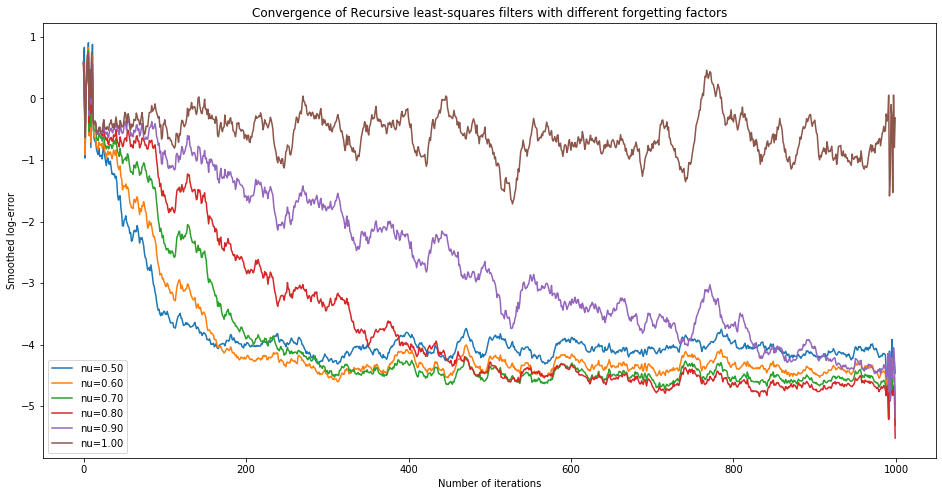

In [28]:
plt.rcParams["figure.figsize"] = (16, 8)

for i in range(n_models):
    ys = moving_average(np.log(errors[i]))
    plt.plot(ys, label='nu={0:.2f}'.format(nus[i]))
plt.ylabel('Smoothed log-error')
plt.xlabel('Number of iterations')
plt.title('Convergence of Recursive least-squares filters with different forgetting factors')
plt.legend()
plt.show()

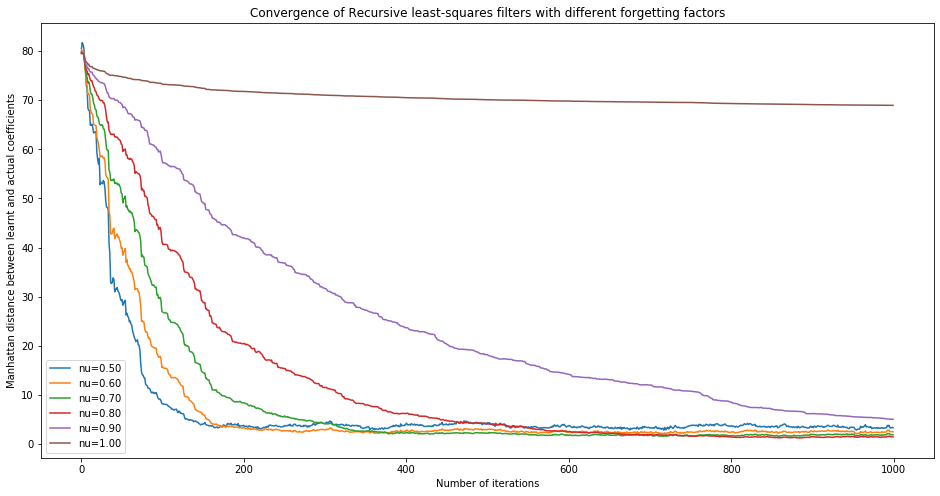

In [31]:
plt.rcParams["figure.figsize"] = (16, 8)

for i in range(n_models):
    ys = manhattan[i]
    plt.plot(ys, label='nu={0:.2f}'.format(nus[i]))
plt.ylabel('Manhattan distance between learnt and actual coefficients')
plt.xlabel('Number of iterations')
plt.title('Convergence of Recursive least-squares filters with different forgetting factors')
plt.legend()
plt.show()